In this notebook, we present our preliminary study.

In [1]:
import os
import math
import re
from decimal import Decimal

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

# Open data

We open the train dataset, and quickly check if the data is loaded correctly. We have 8k observations and 26 features.

Since we want to predict the TARGET_FLAG column, this is a binary classification task with unbalanced dataset.

There are some columns with missing values as well, that need to be processed.

In [2]:
df_train = pd.read_csv("auto-insurance-fall-2017/train_auto.csv")

In [3]:
df_train.head()

,INDEX,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,...,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
0,1,0,0.0,0,60.0,0,11.0,"$67,349",No,$0,...,"$14,230",11,Minivan,yes,"$4,461",2,No,3,18.0,Highly Urban/ Urban
1,2,0,0.0,0,43.0,0,11.0,"$91,449",No,"$257,252",...,"$14,940",1,Minivan,yes,$0,0,No,0,1.0,Highly Urban/ Urban
2,4,0,0.0,0,35.0,1,10.0,"$16,039",No,"$124,191",...,"$4,010",4,z_SUV,no,"$38,690",2,No,3,10.0,Highly Urban/ Urban
3,5,0,0.0,0,51.0,0,14.0,NaN,No,"$306,251",...,"$15,440",7,Minivan,yes,$0,0,No,0,6.0,Highly Urban/ Urban
4,6,0,0.0,0,50.0,0,NaN,"$114,986",No,"$243,925",...,"$18,000",1,z_SUV,no,"$19,217",2,Yes,3,17.0,Highly Urban/ Urban


In [4]:
df_train.shape

(8161, 26)

In [5]:
df_train.dtypes

INDEX            int64
TARGET_FLAG      int64
TARGET_AMT     float64
KIDSDRIV         int64
AGE            float64
HOMEKIDS         int64
YOJ            float64
INCOME          object
PARENT1         object
HOME_VAL        object
MSTATUS         object
SEX             object
EDUCATION       object
JOB             object
TRAVTIME         int64
CAR_USE         object
BLUEBOOK        object
TIF              int64
CAR_TYPE        object
RED_CAR         object
OLDCLAIM        object
CLM_FREQ         int64
REVOKED         object
MVR_PTS          int64
CAR_AGE        float64
URBANICITY      object
dtype: object

In [6]:
# We will drop these columns
DROP_COLUMNS = ['INDEX',
                'TARGET_AMT']

# The target column
TARGET = 'TARGET_FLAG'

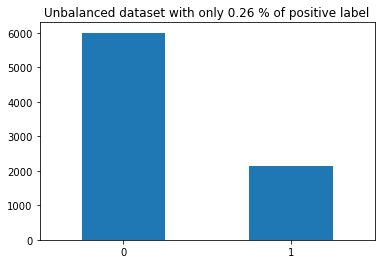

In [7]:
df_train[TARGET].value_counts().plot(kind='bar', rot=0)
plt.title('Unbalanced dataset with only {0:0.2f} % of positive label'.format(df_train[TARGET].mean()))
plt.show()

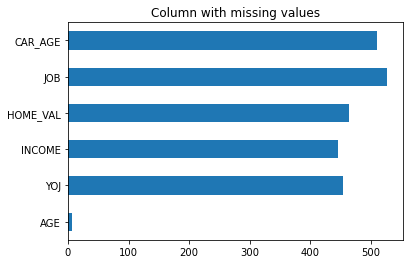

In [8]:
is_column_with_na = df_train.isna().sum()
is_column_with_na[is_column_with_na != 0].plot.barh()
plt.title('Column with missing values')
plt.show()

# Float features

We have AGE, YOJ and CAR_AGE as float features.

In [9]:
float_dtypes_idx = np.where((df_train.dtypes == np.float))[0] 

In [10]:
df_train.iloc[:, float_dtypes_idx].head()

,TARGET_AMT,AGE,YOJ,CAR_AGE
0,0.0,60.0,11.0,18.0
1,0.0,43.0,11.0,1.0
2,0.0,35.0,10.0,10.0
3,0.0,51.0,14.0,6.0
4,0.0,50.0,NaN,17.0


# Integer features

We have some integer features which can represent either continuous distribution or ordinal distribution.

In [11]:
int_dtypes_idx = np.where((df_train.dtypes == np.int))[0] 

In [12]:
df_train.iloc[:, int_dtypes_idx].head()

,INDEX,TARGET_FLAG,KIDSDRIV,HOMEKIDS,TRAVTIME,TIF,CLM_FREQ,MVR_PTS
0,1,0,0,0,14,11,2,3
1,2,0,0,0,22,1,0,0
2,4,0,0,1,5,4,2,3
3,5,0,0,0,32,7,0,0
4,6,0,0,0,36,1,2,3


# Object column

As we want to use scikit-learn to learn from the data, we need to adapt the object columns accordingly (since scikit-learn does not handle object input).

In [13]:
object_dtypes_idx = np.where((df_train.dtypes != np.float) & (df_train.dtypes != np.int))[0] 

In [14]:
df_train.iloc[:, object_dtypes_idx].head()

,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,EDUCATION,JOB,CAR_USE,BLUEBOOK,CAR_TYPE,RED_CAR,OLDCLAIM,REVOKED,URBANICITY
0,"$67,349",No,$0,z_No,M,PhD,Professional,Private,"$14,230",Minivan,yes,"$4,461",No,Highly Urban/ Urban
1,"$91,449",No,"$257,252",z_No,M,z_High School,z_Blue Collar,Commercial,"$14,940",Minivan,yes,$0,No,Highly Urban/ Urban
2,"$16,039",No,"$124,191",Yes,z_F,z_High School,Clerical,Private,"$4,010",z_SUV,no,"$38,690",No,Highly Urban/ Urban
3,NaN,No,"$306,251",Yes,M,<High School,z_Blue Collar,Private,"$15,440",Minivan,yes,$0,No,Highly Urban/ Urban
4,"$114,986",No,"$243,925",Yes,z_F,PhD,Doctor,Private,"$18,000",z_SUV,no,"$19,217",Yes,Highly Urban/ Urban


## Dollars columns

First, we convert the string columns storing amount of dollars into floatting point values.

In [15]:
object_dtypes_idx = np.where((df_train.dtypes != np.float) & (df_train.dtypes != np.int))[0] 
df_train.iloc[:, object_dtypes_idx].head()

,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,EDUCATION,JOB,CAR_USE,BLUEBOOK,CAR_TYPE,RED_CAR,OLDCLAIM,REVOKED,URBANICITY
0,"$67,349",No,$0,z_No,M,PhD,Professional,Private,"$14,230",Minivan,yes,"$4,461",No,Highly Urban/ Urban
1,"$91,449",No,"$257,252",z_No,M,z_High School,z_Blue Collar,Commercial,"$14,940",Minivan,yes,$0,No,Highly Urban/ Urban
2,"$16,039",No,"$124,191",Yes,z_F,z_High School,Clerical,Private,"$4,010",z_SUV,no,"$38,690",No,Highly Urban/ Urban
3,NaN,No,"$306,251",Yes,M,<High School,z_Blue Collar,Private,"$15,440",Minivan,yes,$0,No,Highly Urban/ Urban
4,"$114,986",No,"$243,925",Yes,z_F,PhD,Doctor,Private,"$18,000",z_SUV,no,"$19,217",Yes,Highly Urban/ Urban


In [16]:
DOLLARS_COLUMNS = ['INCOME',
                   'HOME_VAL',
                   'BLUEBOOK',
                   'OLDCLAIM'
                  ]

def replace_dollar_comma_sign(money):
    """
        Given a string representing an amount of money, return the corresponding float representation.
    """
    if type(money) is not str and math.isnan(money):
        return np.nan
    else:
        return float(Decimal(re.sub(r'[^\d.]', '', money)))
    
for column in DOLLARS_COLUMNS:
    df_train.loc[:, column] = df_train.loc[:, column].apply(replace_dollar_comma_sign)
    df_train.loc[:, column] = df_train.loc[:, column].apply(np.log)
    df_train.loc[:, column] = df_train.loc[:, column].replace({-np.inf: 1})
    
# Show processed columns
df_train.loc[:, DOLLARS_COLUMNS].head()

,INCOME,HOME_VAL,BLUEBOOK,OLDCLAIM
0,11.117643,1.000000,9.563108,8.403128
1,11.423537,12.457811,9.611797,1.000000
2,9.682779,11.729576,8.296547,10.563336
3,NaN,12.632160,9.644717,1.000000
4,11.652566,12.404616,9.798127,9.863551


## Binary columns

Among the remaining object dtypes columns, there are some binary columns with Yes/No value which can be easily mapped into binary 1/0 value.

In [17]:
BINARY_COLUMNS = ['PARENT1',
                  'MSTATUS',
                  'RED_CAR',
                  'REVOKED']

replace_binary_dict = {'No'  : 0,
                       'z_No': 0,
                       'no'  : 0,
                       'Yes' : 1,
                       'yes' : 1}

for column in BINARY_COLUMNS:
    df_train.loc[:, column] = df_train.loc[:, column].replace(replace_binary_dict)
    
df_train.loc[:, BINARY_COLUMNS].head()

,PARENT1,MSTATUS,RED_CAR,REVOKED
0,0,0,1,0
1,0,0,1,0
2,0,1,0,0
3,0,1,1,0
4,0,1,0,1


## Ordinal variable

The 'education' column is a bit different since we can define an ordinal ordering between the categories. For instance, 'PhD' is a higher level of study than 'Master', which is higher than 'Bachelors', and so on. For this reason, it makes sense to map High School to 0, Bachelors to 1, and so on ... 

In [18]:
LABEL = 'EDUCATION'

df_train.loc[:, LABEL].replace({'z_High School': '<High School'}, inplace=True)
df_train.loc[:, LABEL].replace({'<High School': 0,
                                'Bachelors'   : 1,
                                'Masters'     : 2,
                                'PhD'         : 3}, inplace=True)
df_train.loc[:, [LABEL]].head()

,EDUCATION
0,3
1,0
2,0
3,0
4,3


## Columns with multiple modes

The columns 'JOB', 'CAR_TYPE' can have multiple modes, we will define a one hot encoding to map the columns into one hot vectors.

In [19]:
object_dtypes_idx = np.where((df_train.dtypes != np.float) & (df_train.dtypes != np.int))[0] 
df_train.iloc[:, object_dtypes_idx].head()

,SEX,JOB,CAR_USE,CAR_TYPE,URBANICITY
0,M,Professional,Private,Minivan,Highly Urban/ Urban
1,M,z_Blue Collar,Commercial,Minivan,Highly Urban/ Urban
2,z_F,Clerical,Private,z_SUV,Highly Urban/ Urban
3,M,z_Blue Collar,Private,Minivan,Highly Urban/ Urban
4,z_F,Doctor,Private,z_SUV,Highly Urban/ Urban


In [20]:
# Inputting missing value for JOB

LABEL = 'JOB'
most_frequent_job = df_train.loc[:, LABEL].value_counts().index[0]
df_train.loc[:, LABEL].fillna(most_frequent_job, inplace=True)

In [21]:
most_frequent_job

'z_Blue Collar'

In [22]:
enc = OneHotEncoder(handle_unknown='ignore')
features = enc.fit_transform(df_train.iloc[:, object_dtypes_idx]).toarray()

df_train.drop(columns=df_train.columns[object_dtypes_idx], inplace=True)
new_columns = []
i = 0
for category in enc.categories_:
    # We keep only one column for binary categorical features
    if len(category) == 2:
        new_column = category[0]
        df_train[new_column] = features[:, i]
        new_columns.append(new_column)
        i += 2
    # O.W, we use one-hot-encoding
    else:
        for new_column in category:
            df_train[new_column] = features[:, i]
            new_columns.append(new_column)
            i += 1
            
df_train.loc[:, new_columns].head()

,M,Clerical,Doctor,Home Maker,Lawyer,Manager,Professional,Student,z_Blue Collar,Commercial,Minivan,Panel Truck,Pickup,Sports Car,Van,z_SUV,Highly Urban/ Urban
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


# Conclusion

In this notebook, we show how to get the first insights of our dataset.

We show how to get to perform basic preprocessing.

* We converted amount of dollars stored in string to float values.

* We try ordinal encoding for the EDUCATION column.

* We transform categorical features with one hot encoding.

* We inputted missing values for the JOB column with the most frequent jobs. We will input the remaining missing values for numerical value at training time (after splitting into val/test).

In [23]:
df_train.drop(columns=DROP_COLUMNS, inplace=True)

In [24]:
df_train.head()

,TARGET_FLAG,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,EDUCATION,...,Student,z_Blue Collar,Commercial,Minivan,Panel Truck,Pickup,Sports Car,Van,z_SUV,Highly Urban/ Urban
0,0,0,60.0,0,11.0,11.117643,0,1.000000,0,3,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,0,43.0,0,11.0,11.423537,0,12.457811,0,0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0,0,35.0,1,10.0,9.682779,0,11.729576,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,0,0,51.0,0,14.0,NaN,0,12.632160,1,0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0,0,50.0,0,NaN,11.652566,0,12.404616,1,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [25]:
new_dir = 'notebook_insights'

if not os.path.exists(new_dir):
    os.mkdir(new_dir)
    
df_train.to_csv(os.path.join(new_dir, 'preprocessed_train.csv'), index=None)